In [625]:
# get pair of records with few tokens
# ask the LLM for the prediction using prompt 1
# ask the LLM for the prediction using prompt 2
# check that the prediction is the same
# compare saliency explanations
# see how much they differ
# calculate kendall-tau?
# compare counterfactual explanations
# see how much they differ
# check for their validity manually

In [691]:
import pandas as pd
from certa.utils import merge_sources
import ellmer.models
import ellmer.metrics
import matplotlib.pyplot as plt

In [627]:
dataset = 'amazon_google'
datadir = '/Users/tteofili/dev/cheapER/datasets/' + dataset
lsource = pd.read_csv(datadir + '/tableA.csv')
rsource = pd.read_csv(datadir + '/tableB.csv')
gt = pd.read_csv(datadir + '/train.csv')
valid = pd.read_csv(datadir + '/valid.csv')
test = pd.read_csv(datadir + '/test.csv')

In [628]:
model_type="azure_openai"
model_name="gpt-3.5-turbo"
deployment_name="gpt-35-turbo"
explanation_granularity="token"
temperature=0

In [ ]:
test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])

In [690]:
# both good: ag#152,154, 160, 177, 181
# pase weird: ag#155
# both bad but acceptable: ag#159
# pase good, ptse bad: ag#161, 166, 170
idx = 184
rand_row = test_df.iloc[[idx]]
l_id = int(rand_row['ltable_id'])
l_tuple = lsource.iloc[l_id]
r_id = int(rand_row['rtable_id'])
r_tuple = rsource.iloc[r_id]
ltuple, rtuple = ellmer.utils.get_tuples(rand_row)
rand_row.drop(['ltable_id','rtable_id'], axis=1).head()

,label,ltable_title,ltable_manufacturer,ltable_price,rtable_title,rtable_manufacturer,rtable_price
184,0,quickbooks premier edition 2007 5 user multi-pack,intuit,1499.95,intuit quickbooks premier professional service...,NaN,349.95


In [ ]:
pase = ellmer.models.GenericEllmer(explanation_granularity=explanation_granularity,
                                       deployment_name=deployment_name, temperature=temperature,
                                       model_name=model_name, model_type=model_type, verbose=False,
                                       prompts={"pase": "../ellmer/prompts/constrained10.txt"})

In [681]:
pase_answer_dictionary = pase.predict_and_explain(ltuple, rtuple)
pase_answer_dictionary

{'prediction': 0,
 'saliency': {'quickbooks': 0.2,
  'premier': 0.3,
  'edition': 0.1,
  '2007': 0.4,
  '5': 0.0,
  'user': 0.0,
  'multi-pack': 0.0,
  'intuit': 0.5,
  'manufacturer': 0.0,
  'price': 0.0},
 'cf': {'ltable_title': 'quickbooks premier edition 2007 5 user multi-pack',
  'ltable_manufacturer': 'intuit',
  'ltable_price': '1499.95',
  'rtable_title': 'intuit quickbooks premier professional services edition 2007 software win tax & finance software',
  'rtable_manufacturer': 'intuit',
  'rtable_price': '1499.95'}}

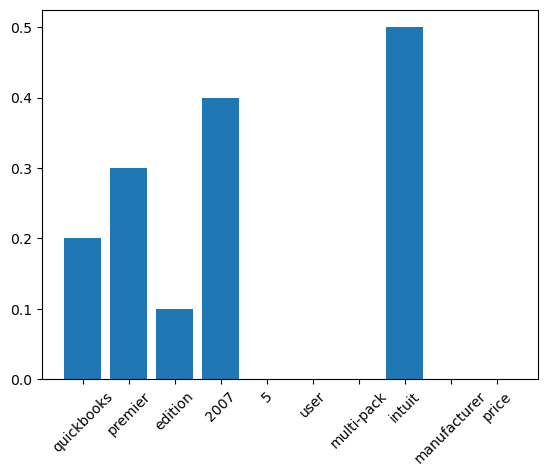

In [694]:
plt.bar(*zip(*pase_answer_dictionary['saliency'].items()))
plt.xticks(rotation=45)
plt.show()

In [682]:
pase_cf_pair = pd.DataFrame(pd.Series(pase_answer_dictionary['cf'])).T
pase_cf_pair

,ltable_title,ltable_manufacturer,ltable_price,rtable_title,rtable_manufacturer,rtable_price
0,quickbooks premier edition 2007 5 user multi-pack,intuit,1499.95,intuit quickbooks premier professional service...,intuit,1499.95


In [683]:
pase_cf_ltuple, pase_cf_rtuple = ellmer.utils.get_tuples(pase_cf_pair)
pase_cf_answer_dictionary = pase.predict_and_explain(pase_cf_ltuple, pase_cf_rtuple)
pase_cf_answer_dictionary['prediction']

1

In [ ]:
ptse = ellmer.models.GenericEllmer(explanation_granularity=explanation_granularity,
                                        deployment_name=deployment_name, temperature=temperature,
                                        model_name=model_name, model_type=model_type,
                                        prompts={"ptse": {"er": "../ellmer/prompts/er.txt",
                                                     "saliency": "../ellmer/prompts/er-saliency-lc.txt",
                                                     "cf": "../ellmer/prompts/er-cf-lc.txt"}})

In [709]:
ptse_answer_dictionary = ptse.predict_and_explain(ltuple, rtuple)
ptse_answer_dictionary

{'prediction': 0,
 'why': None,
 'saliency': {'quickbooks': 0.2,
  'premier': 0.2,
  'edition': 0.2,
  '2007': 0.2,
  'intuit': 0.4,
  '5': 0.2,
  'user': 0.2,
  'multi-pack': 0.2,
  'software': 0.2,
  'win': 0.2,
  'tax': 0.2,
  'finance': 0.2,
  'nan': 0.4,
  '349.95': 0.2,
  '1499.95': 0.2},
 'cf': {'ltable_title': 'quickbooks premier edition 2007 5 user multi-pack',
  'ltable_manufacturer': 'intuit',
  'ltable_price': '1499.95',
  'rtable_title': 'intuit quickbooks premier professional services edition 2007 software win tax & finance software',
  'rtable_manufacturer': 'intuit',
  'rtable_price': '1499.95'}}

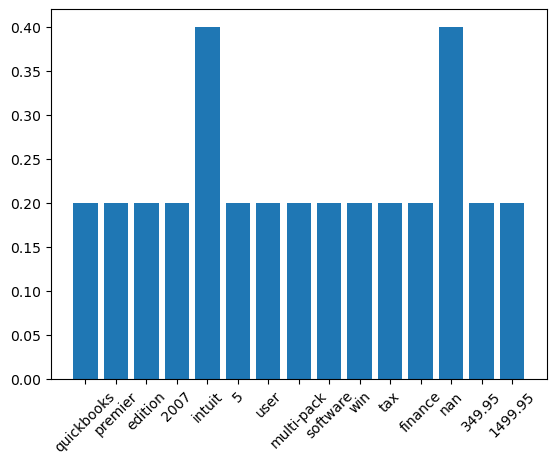

In [710]:
plt.bar(*zip(*ptse_answer_dictionary['saliency'].items()))
plt.xticks(rotation=45)
plt.show()

In [712]:
ptse_cf_pair = pd.DataFrame(pd.Series(ptse_answer_dictionary['cf'])).T
ptse_cf_pair

,ltable_title,ltable_manufacturer,ltable_price,rtable_title,rtable_manufacturer,rtable_price
0,quickbooks premier edition 2007 5 user multi-pack,intuit,1499.95,intuit quickbooks premier professional service...,intuit,1499.95


In [713]:
ptse_cf_ltuple, ptse_cf_rtuple = ellmer.utils.get_tuples(ptse_cf_pair)
ptse_cf_answer_dictionary = ptse.predict_and_explain(ptse_cf_ltuple, ptse_cf_rtuple)
ptse_cf_answer_dictionary['prediction']

1

In [721]:
ptsew = ellmer.models.GenericEllmer(explanation_granularity=explanation_granularity,
                                        deployment_name=deployment_name, temperature=temperature,
                                        model_name=model_name, model_type=model_type,
                                        prompts={"ptse": {"er": "../ellmer/prompts/er.txt",
                                                     "why": "../ellmer/prompts/er-why.txt",
                                                     "saliency": "../ellmer/prompts/er-saliency-lc.txt",
                                                     "cf": "../ellmer/prompts/er-cf-lc.txt"}})

In [722]:
ptsew_answer_dictionary = ptsew.predict_and_explain(ltuple, rtuple)
ptsew_answer_dictionary

{'prediction': 0,
 'why': 'The two records do not match because they have different titles, different manufacturers, and different prices. Although both records refer to QuickBooks Premier Edition 2007, they are different versions of the software with different features and prices. Therefore, they are not the same product and should not be considered a match.',
 'saliency': {'quickbooks': 1.0,
  'premier': 1.0,
  'edition': 1.0,
  '2007': 1.0,
  '5': 0.5,
  'user': 0.5,
  'multi-pack': 0.5,
  'intuit': 1.0,
  'professional': 0.5,
  'services': 0.5,
  'software': 0.5,
  'win': 0.5,
  'tax': 0.5,
  'finance': 0.5,
  'nan': 0.5,
  '349.95': 0.5,
  '1499.95': 0.5},
 'cf': {'ltable_title': 'intuit quickbooks premier professional services edition 2007 software win tax & finance software',
  'ltable_manufacturer': 'intuit',
  'ltable_price': '349.95',
  'rtable_title': 'quickbooks premier edition 2007 5 user multi-pack',
  'rtable_manufacturer': 'nan',
  'rtable_price': '1499.95'}}

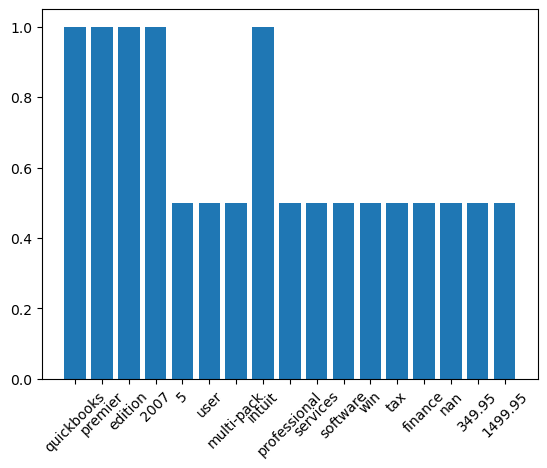

In [723]:
plt.bar(*zip(*ptsew_answer_dictionary['saliency'].items()))
plt.xticks(rotation=45)
plt.show()

In [724]:
ptsew_cf_pair = pd.DataFrame(pd.Series(ptsew_answer_dictionary['cf'])).T
ptsew_cf_pair

,ltable_title,ltable_manufacturer,ltable_price,rtable_title,rtable_manufacturer,rtable_price
0,intuit quickbooks premier professional service...,intuit,349.95,quickbooks premier edition 2007 5 user multi-pack,nan,1499.95


In [725]:
ptsew_cf_ltuple, ptsew_cf_rtuple = ellmer.utils.get_tuples(ptsew_cf_pair)
ptsew_cf_answer_dictionary = ptsew.predict_and_explain(ptsew_cf_ltuple, ptsew_cf_rtuple)
ptsew_cf_answer_dictionary['prediction']

0

In [726]:
ptsew_cf_answer_dictionary['why']

'The two records do not match because they have different titles and manufacturers. Although both records contain the word "QuickBooks Premier Edition 2007", the first record has additional information about being a "Professional Services Edition" and having "Tax & Finance Software". Additionally, the manufacturers are different, with the first record being from "Intuit" and the second record having a missing manufacturer value. Finally, the prices are different, with the first record being priced at $349.95 and the second record being priced at $1499.95.'